# Are there differences in sources of inspiration?

## Imports and loader functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

import cv2
import numpy as np
import PIL
import os
import re

In [2]:
def imshow(img):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img).convert("RGB"))
    
def imshow_on_axis(img, ax, title):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

            
def load_images_from_path(path, number):
    images = []
    srcs = []
    pattern = rf"^{number}(?!\d)"
    
    for filename in os.listdir(path):
        if re.match(pattern, filename):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                images.append(img)
                srcs.append(filename)

    return images, srcs


def load_images(number):
    final_images = []
    final_srcs = []

    final_path = f"data/final_submissions/{number}/"
    web_path = "data/web/"
    ai_path = "data/ai/"

    if not os.path.exists(final_path):
        print(f"The final submissions path '{final_path}' does not exist.")
        return None, None, None

    for filename in os.listdir(final_path):
        img = cv2.imread(os.path.join(final_path, filename))
        if img is not None:
            final_images.append(img)
            final_srcs.append(f"{number}_{filename}")

    web_images, web_srcs = load_images_from_path(web_path, number)
    ai_images, ai_srcs = load_images_from_path(ai_path, number)

    if not final_images:
        print(f"No images found in '{final_path}'. Please check the contents.")
        return None, None, None

    if not web_images and not ai_images:
        print(
            f"The number '{number}' does not correspond to any valid images in 'web' or 'ai' folders."
        )
        return None, None, None

    if not web_images:
        print(f"No web images found with prefix '{number}' in '{web_path}'.")
        return None, None, None
    if not ai_images:
        print(f"No AI images found with prefix '{number}' in '{ai_path}'.")
        return None, None, None

    return final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs

In [3]:
def read_csv(path):
    try:
        df = pd.read_csv(path)
        return df
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

## Analyze of plots


In [4]:
resnets_temp=[]
new_columns = ["Final_Submission", "Inspiration", "Similarity"]

for i in range(1,26):
    resnets_temp.append(read_csv(f"csv/csv2/{i}.csv"))
#Temp fix cause we still dont have all data for 26 group
resnets_temp.append(read_csv(f"csv/csv2/27.csv"))

resnets = pd.concat(resnets_temp, ignore_index=True)
resnets.columns = new_columns
resnets["Final_Submission"] = resnets["Final_Submission"].apply(lambda x: "_".join(x.split('/')[-2:]))
resnets["Inspiration"] = resnets["Inspiration"].apply(lambda x: x.split('/')[-1])


colors = read_csv("csv/color_similarity.csv")

dinos=read_csv("csv/dino_similarity.csv")
dinos.columns = new_columns
dinos["Final_Submission"] = dinos["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
dinos["Inspiration"] = dinos["Inspiration"].apply(lambda x: x.split('\\')[-1])

contrasts = read_csv("csv/contrast_similarity.csv")
contrasts.columns = new_columns
contrasts["Final_Submission"] = contrasts["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
contrasts["Inspiration"] = contrasts["Inspiration"].apply(lambda x: x.split('\\')[-1])


print(colors.shape)
print(resnets.shape)
print(dinos.shape)
print(contrasts.shape)

(8837, 3)
(8837, 3)
(5500, 3)
(8881, 3)


In [5]:
colors.head()

Final_Submission Inspiration  Similarity
0          1_1.png    1A_1.jpg    0.622241
1          1_1.png   1A_10.jpg    0.886676
2          1_1.png    1A_2.jpg    0.800207
3          1_1.png    1A_3.jpg    0.775083
4          1_1.png    1A_4.jpg    0.815200

In [6]:
resnets.head()

Final_Submission  Inspiration  Similarity
0          1_1.png    1A_11.png    0.818425
1          1_1.png    1A_12.png    0.818425
2          1_1.png    1A_13.png    0.826663
3          1_1.png    1B_11.png    0.843834
4          1_1.png  1B_12_1.png    0.812419

In [7]:
dinos.head()

Final_Submission  Inspiration  Similarity
0          1_1.png    1A_11.png    0.692730
1          1_1.png    1A_12.png    0.692730
2          1_1.png    1A_13.png    0.694256
3          1_1.png    1B_11.png    0.730007
4          1_1.png  1B_12_1.png    0.725263

In [8]:
contrasts.head()

Final_Submission  Inspiration  Similarity
0          1_3.png    1A_11.png    0.725882
1          1_3.png    1A_12.png    0.725882
2          1_3.png    1A_13.png    0.724268
3          1_3.png    1B_11.png    0.739649
4          1_3.png  1B_12_1.png    0.725221

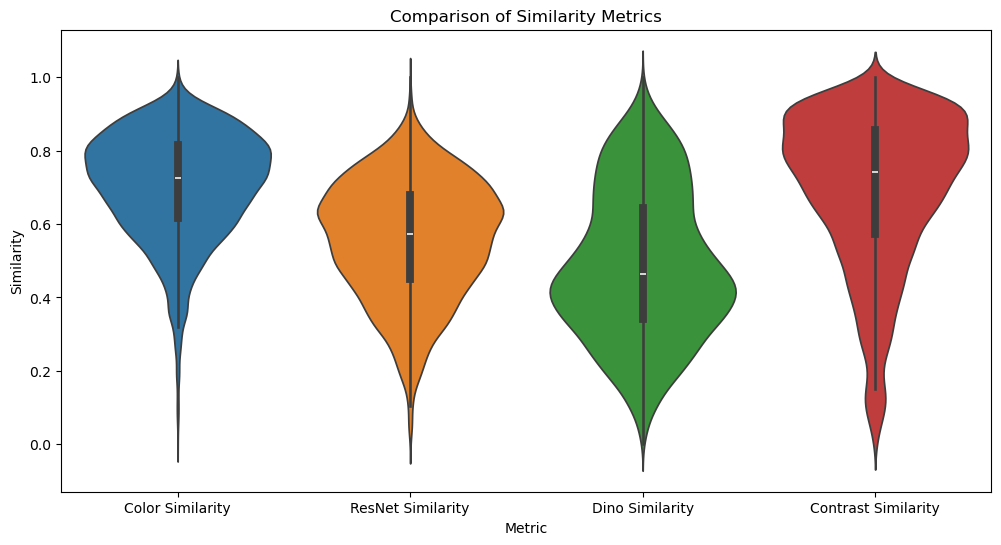

In [9]:
csv_files =[
    colors,
    resnets,
    dinos,
    contrasts
    ]
def zero_one_scale(x:pd.Series):
    return (x-x.min())/(x.max()-x.min())

def standard_scale(x:pd.Series):
    return (x-x.mean())/x.std()


for file in csv_files:
    file["Similarity"] = zero_one_scale(file["Similarity"])
    
metrics = ["Color Similarity", "ResNet Similarity", "Dino Similarity", "Contrast Similarity"]

# Combine each metric into a single DataFrame with a new 'Metric' column
dfs = []
for csv_file, metric in zip(csv_files, metrics):
    df = csv_file.copy()
    df['Metric'] = metric  # Add a column for metric type
    dfs.append(df)

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

# Plot the violin plot with metric type as hue
#plt.figure(figsize=(7.5, 3*len(csv_files)))
plt.figure(figsize=(3*len(csv_files), 6))
sns.violinplot(data=all_data, x="Metric", y="Similarity", hue="Metric")
plt.title("Comparison of Similarity Metrics")
plt.ylabel("Similarity")
plt.xlabel("Metric")
plt.show()

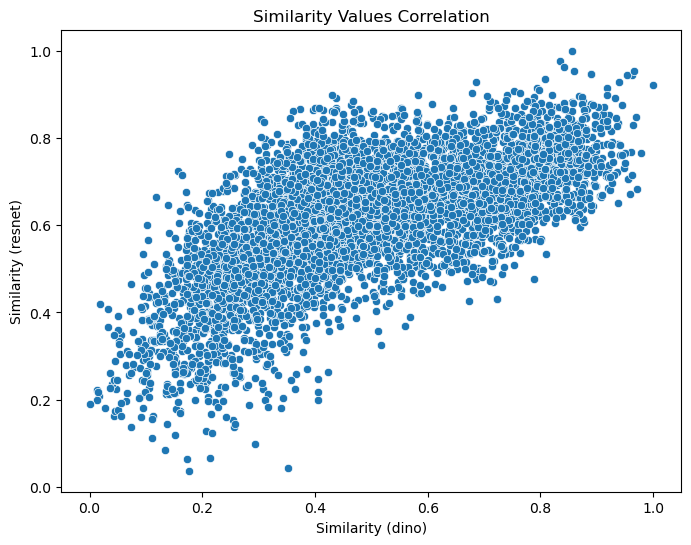

Correlation coefficient: 0.6496048629030382


In [10]:
# Merge the two dataframes on 'Final_Submission' and 'Inspiration'
merged_df = pd.merge(dinos, resnets, on=['Final_Submission', 'Inspiration'], suffixes=('_df1', '_df2'))

# Plot the correlation using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='Similarity_df1', y='Similarity_df2')
plt.title('Similarity Values Correlation')
plt.xlabel('Similarity (dino)')
plt.ylabel('Similarity (resnet)')
plt.show()

# Compute and print the correlation coefficient
correlation = merged_df['Similarity_df1'].corr(merged_df['Similarity_df2'])
print(f'Correlation coefficient: {correlation}')

In [11]:
merge_all=read_csv("csv/all_similarity.csv")
merge_all.head()

Final_Submission Inspiration  Color_Similarity  ResNet_Similarity  \
0          1_1.png    1A_1.jpg          0.529821           0.797856   
1          1_1.png   1A_10.jpg          0.858951           0.604741   
2          1_1.png    1A_2.jpg          0.751328           0.615733   
3          1_1.png    1A_3.jpg          0.720056           0.551096   
4          1_1.png    1A_4.jpg          0.769988           0.652863   

   Dino_Similarity  Contrast_Similarity  
0         0.823561             0.744530  
1         0.716302             0.624540  
2         0.370060             0.883636  
3         0.477145             0.869095  
4         0.437572             0.813474

<Axes: >

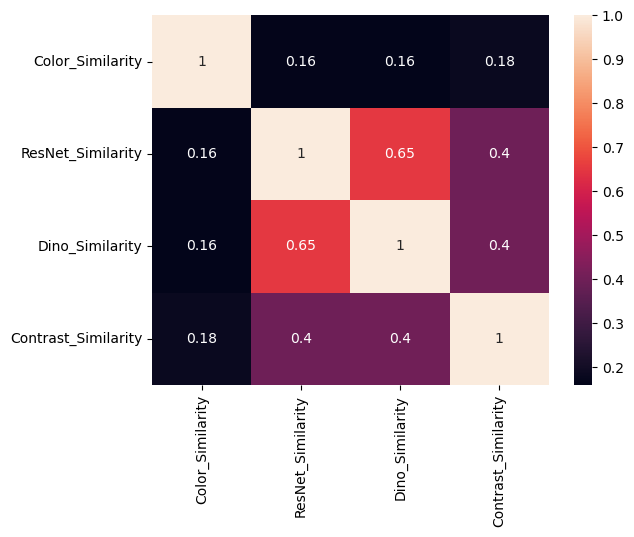

In [12]:
value_cols = ["Color_Similarity", "ResNet_Similarity", "Dino_Similarity", "Contrast_Similarity"]
sns.heatmap(merge_all[value_cols].corr(), annot=True)

In [13]:
combined_df= read_csv("csv/all_similarities_with_srcs.csv")
combined_df.head()

Final_Submission Inspiration  Color_Similarity  ResNet_Similarity  \
0          1_1.png    1A_1.jpg          0.529821           0.797856   
1          1_1.png   1A_10.jpg          0.858951           0.604741   
2          1_1.png    1A_2.jpg          0.751328           0.615733   
3          1_1.png    1A_3.jpg          0.720056           0.551096   
4          1_1.png    1A_4.jpg          0.769988           0.652863   

   Dino_Similarity  Contrast_Similarity Source  
0         0.823561             0.744530    Web  
1         0.716302             0.624540    Web  
2         0.370060             0.883636    Web  
3         0.477145             0.869095    Web  
4         0.437572             0.813474    Web

## See violin plots of inspirations for particular group

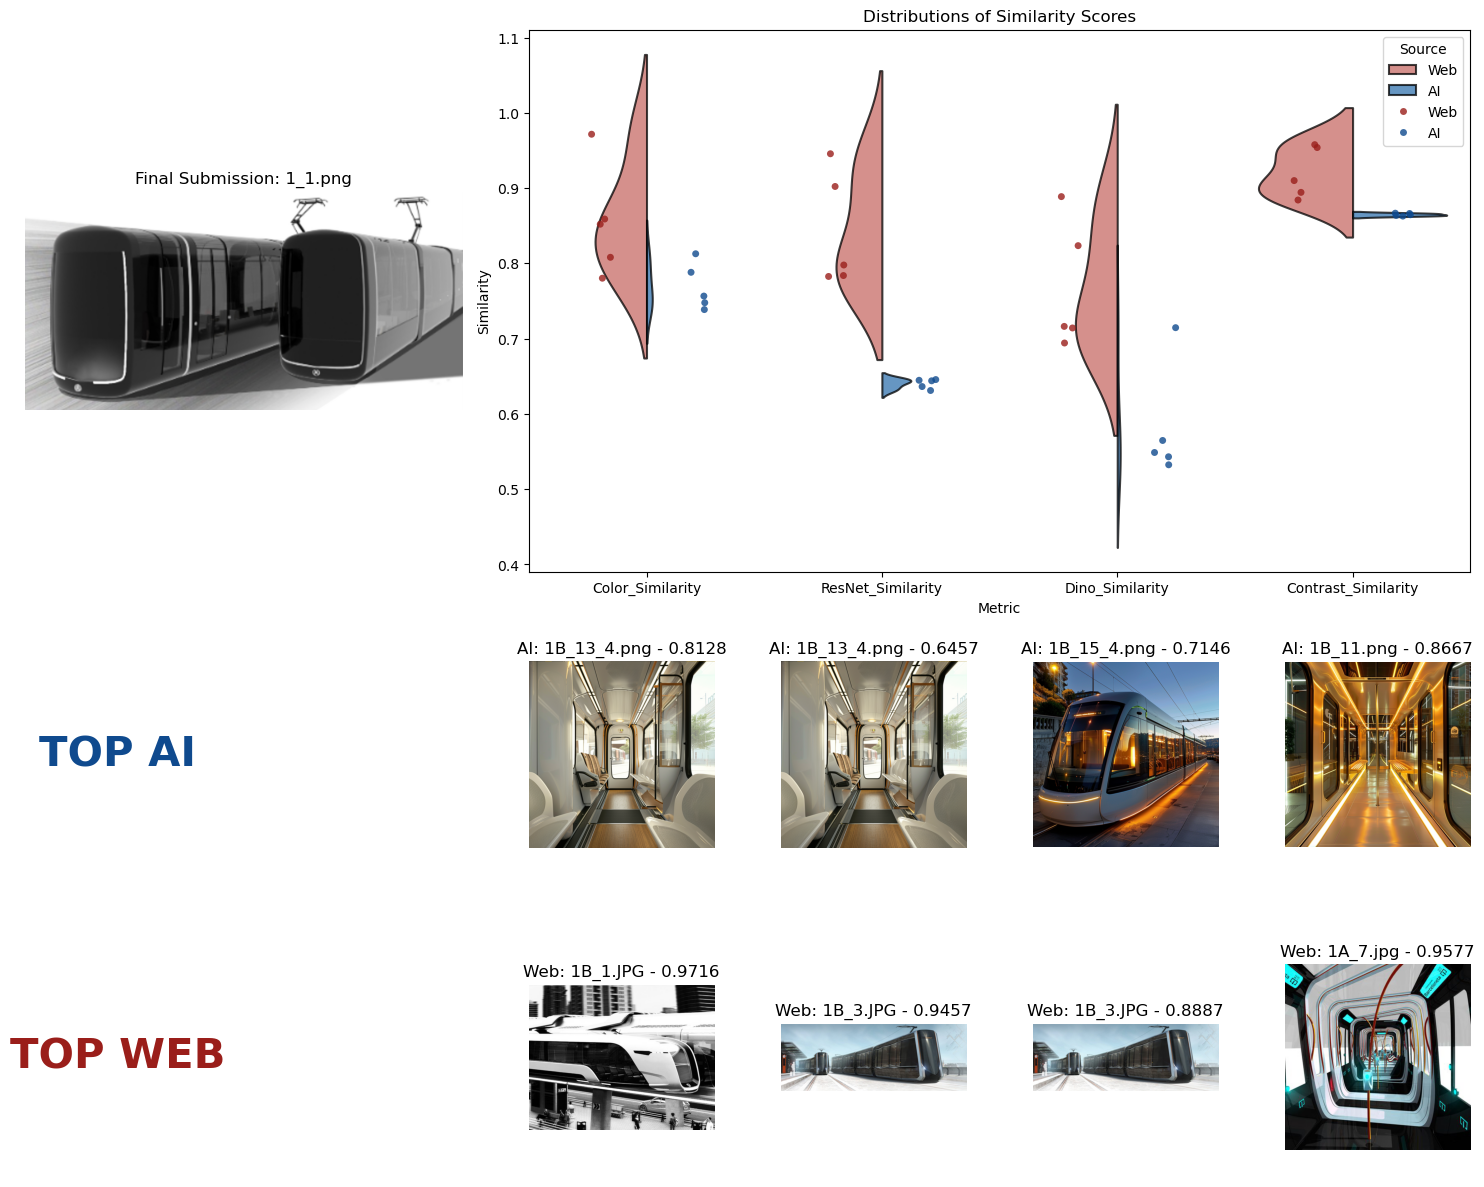

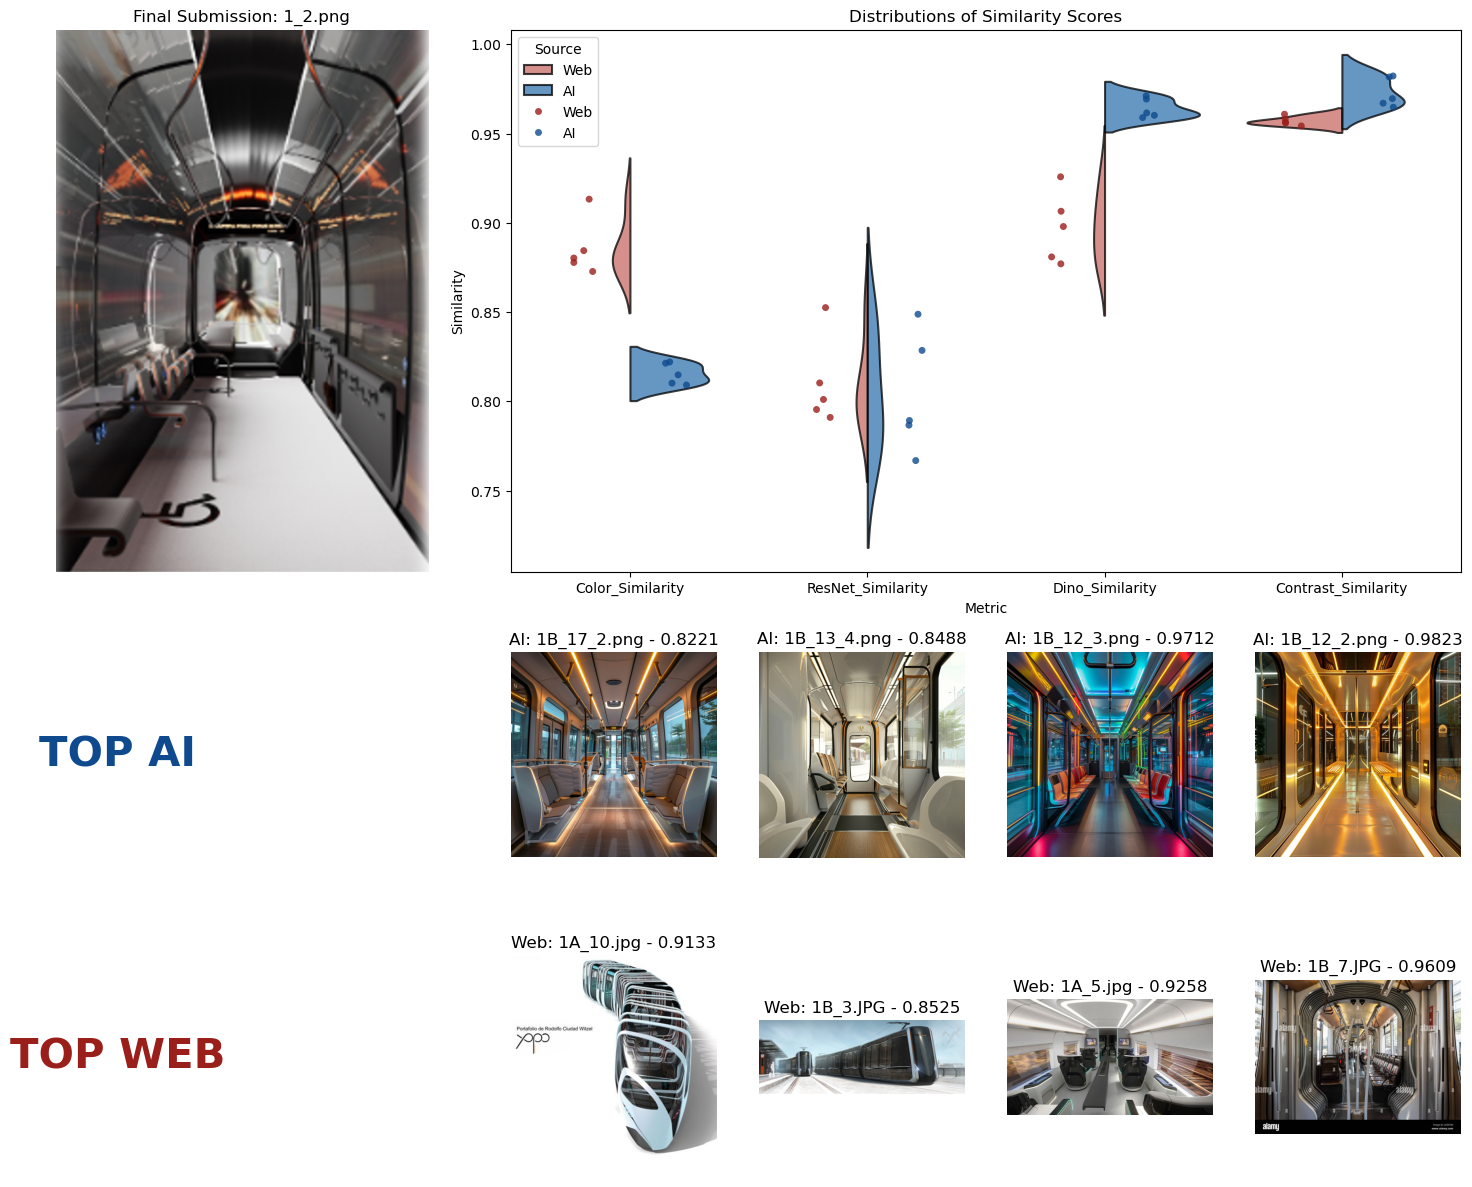

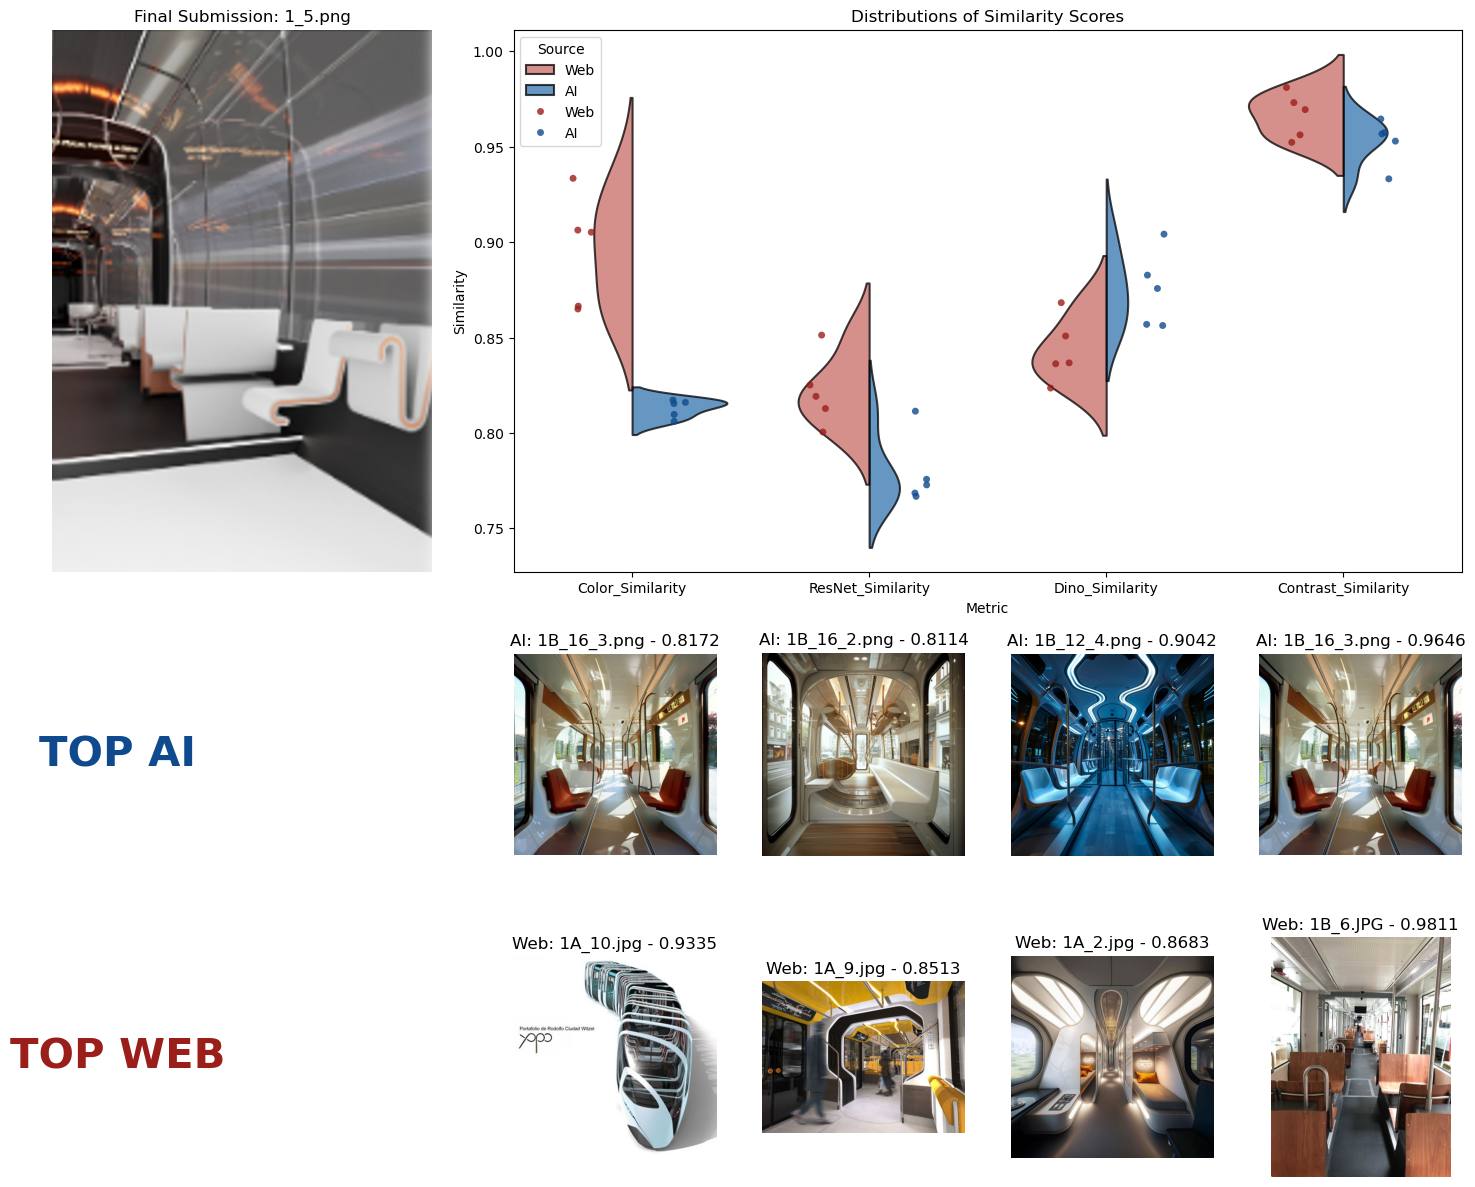

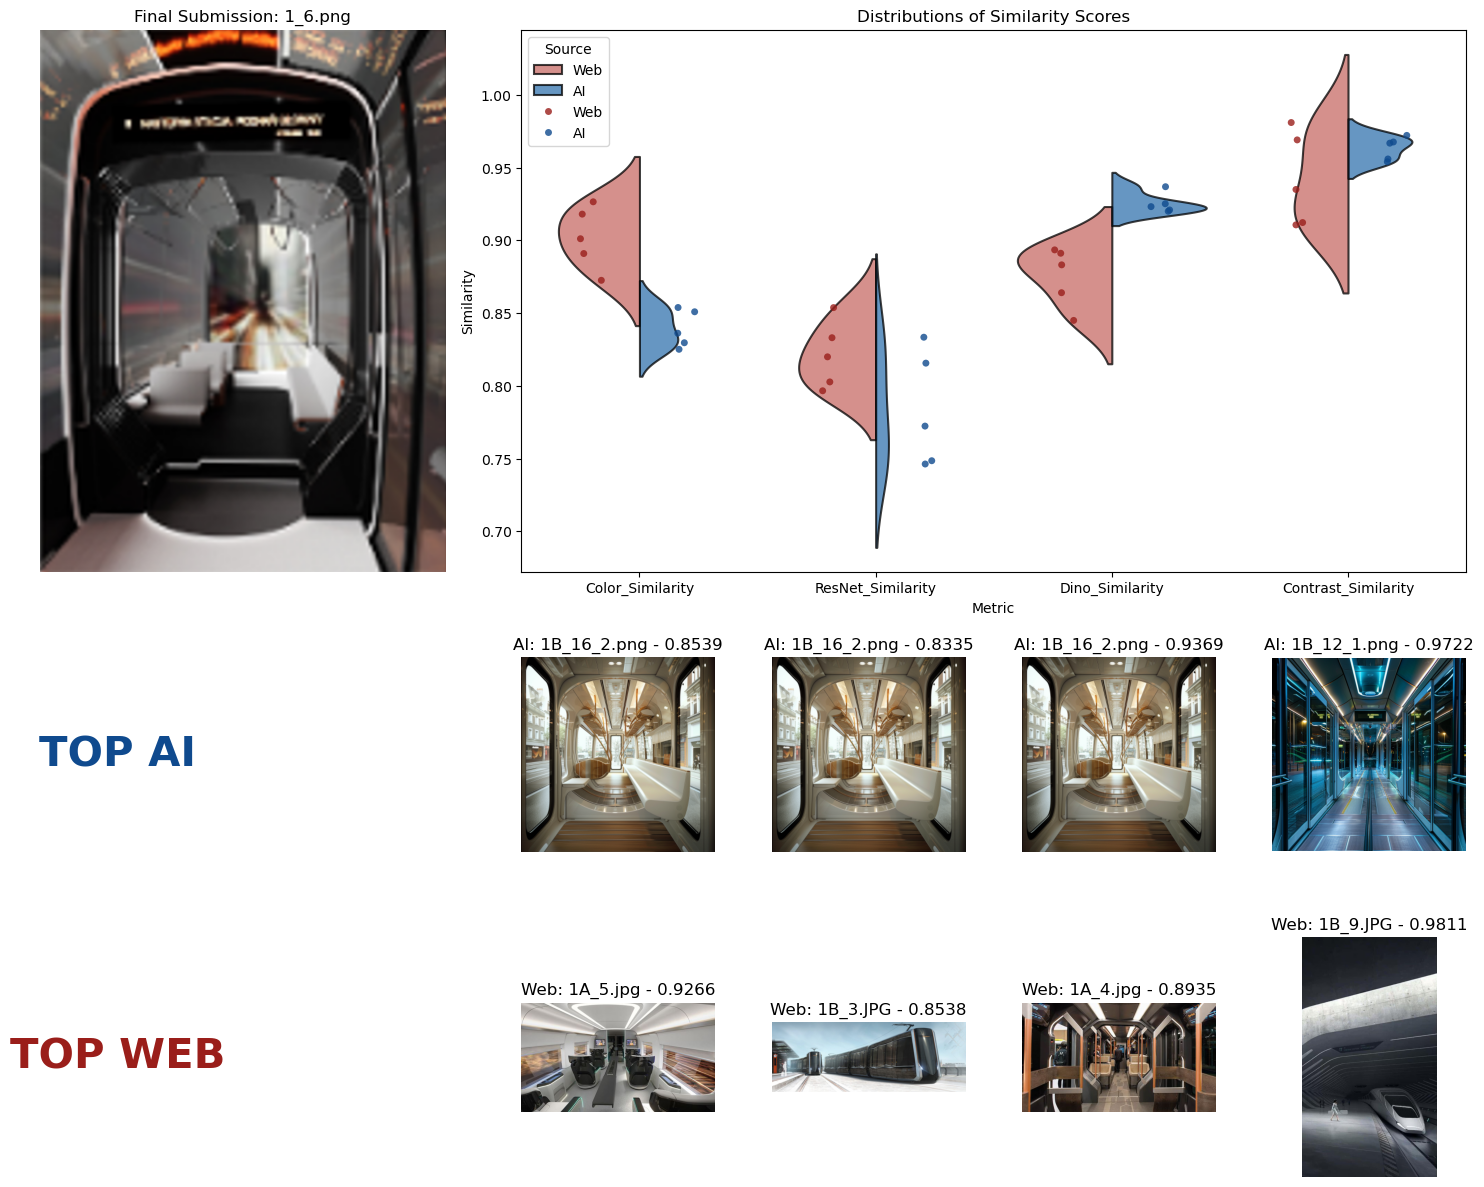

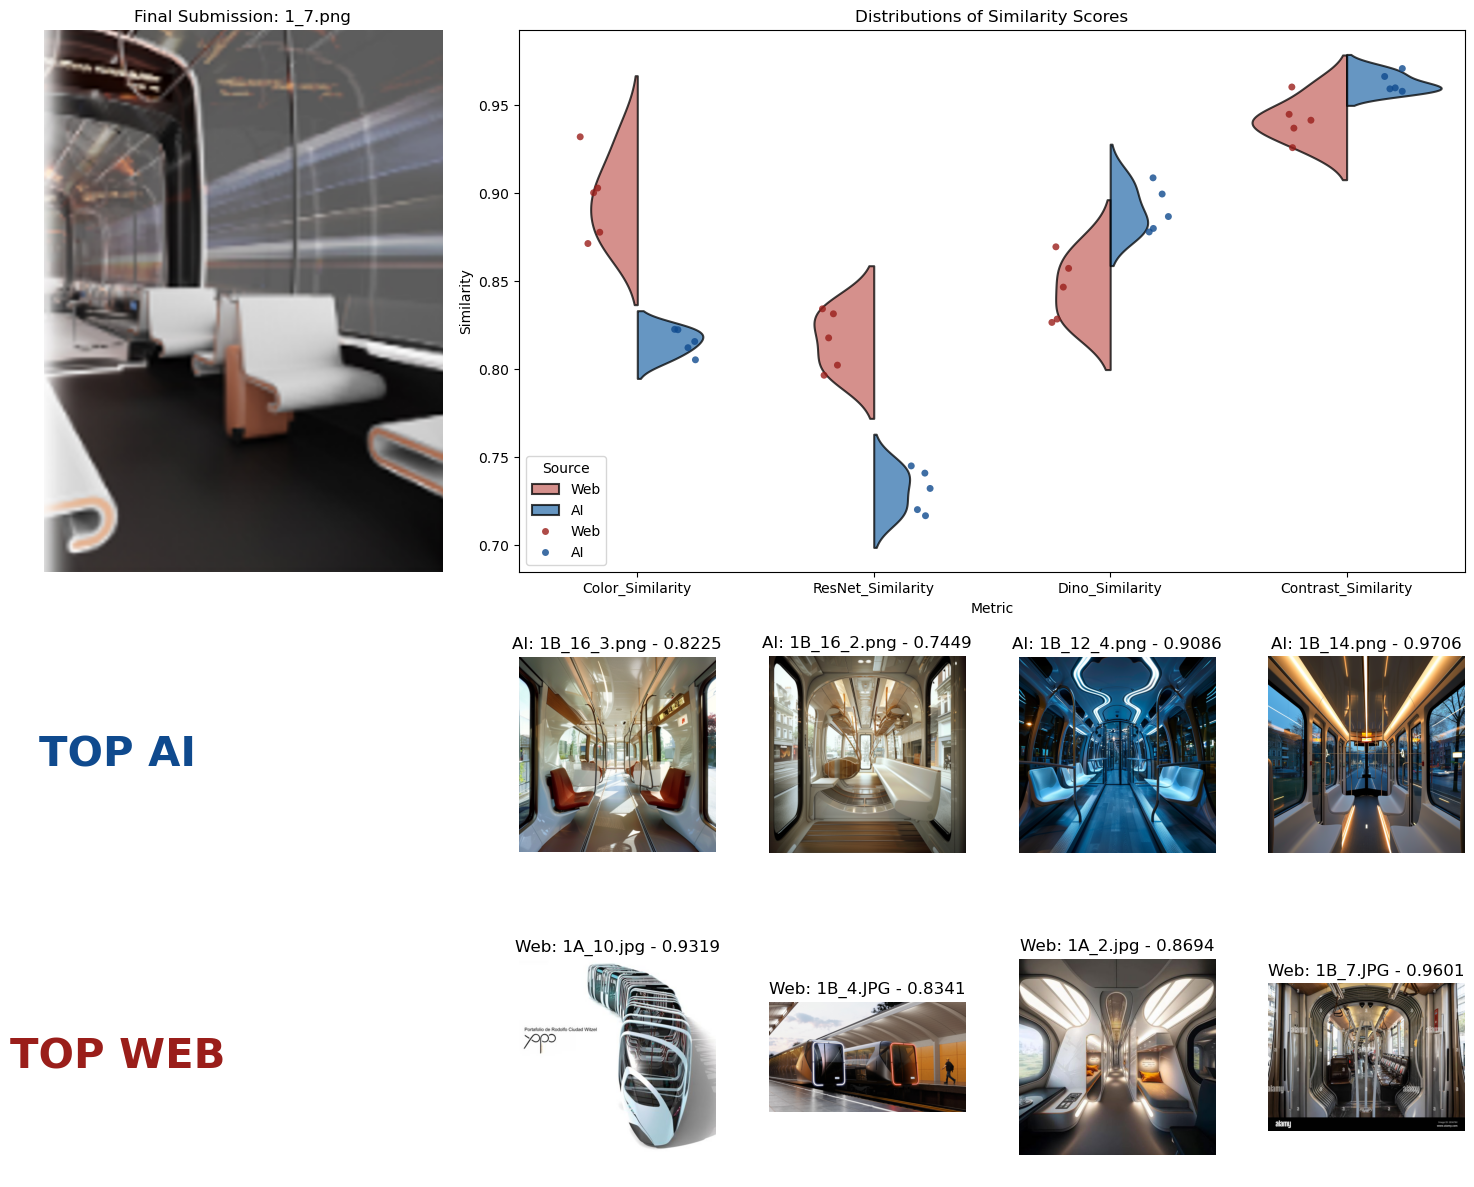

In [14]:
def get_most_similar(df, metric):
    top_row = df.loc[df[metric].idxmax()]
    return top_row[metric], top_row["Inspiration"]


def show_top_simmilarity(group_id, top_count="all"):
    final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs = load_images(
        group_id
    )
    metrics = [
        "Color_Similarity",
        "ResNet_Similarity",
        "Dino_Similarity",
        "Contrast_Similarity",
    ]

    for i in range(len(final_srcs)):
        final_src = final_srcs[i]
        final_image = final_images[i]

        ai_sims = []  # color, resnet, dino, contrast
        ai_sims_srcs = []

        web_sims = []
        web_sims_srcs = []

        final_df = combined_df[combined_df["Final_Submission"] == final_src]
        final_df_web = final_df[final_df["Source"] == "Web"]
        final_df_ai = final_df[final_df["Source"] == "AI"]

        for metric in metrics:
            ai_score, ai_src = get_most_similar(final_df_ai, metric)
            ai_sims.append(ai_score)
            ai_sims_srcs.append(ai_src)

            web_score, web_src = get_most_similar(final_df_web, metric)
            web_sims.append(web_score)
            web_sims_srcs.append(web_src)

        fig = plt.figure(figsize=(15, 15))
        gs = GridSpec(5, 6, figure=fig)

        ax_final_submission = fig.add_subplot(gs[0:2, 0:2])
        imshow_on_axis(
            final_image, ax_final_submission, f"Final Submission: {final_src}"
        )

        ax = fig.add_subplot(gs[2, 0])  # ax for 3,0
        ax.text(
            0.5,
            0.5,
            "TOP AI",
            fontsize=30,
            fontweight="bold",
            ha="center",
            va="center",
            color="#0F4A8E",
        )
        ax.axis("off")

        ax = fig.add_subplot(gs[3, 0])  # ax for 3,0
        ax.text(
            0.5,
            0.5,
            "TOP WEB",
            fontsize=30,
            fontweight="bold",
            ha="center",
            va="center",
            color="#9A1E1A",
        )
        ax.axis("off")

        for i in range(len(csv_files)):
            web_score = web_sims[i]
            web_image = web_images[web_srcs.index(web_sims_srcs[i])]

            ai_score = ai_sims[i]
            ai_image = ai_images[ai_srcs.index(ai_sims_srcs[i])]

            ax_web = fig.add_subplot(gs[3, i + 2])
            imshow_on_axis(
                web_image, ax_web, f"Web: {web_sims_srcs[i]} - {web_score:.4f}"
            )

            ax_ai = fig.add_subplot(gs[2, i + 2])
            imshow_on_axis(ai_image, ax_ai, f"AI: {ai_sims_srcs[i]} - {ai_score:.4f}")

        filtered_df = combined_df[combined_df["Final_Submission"] == final_src]

        combined_df_melted = pd.melt(
            filtered_df,
            id_vars=["Source"],
            value_vars=metrics,
            var_name="Metric",
            value_name="Similarity",
        )

        combined_df_melted["Metric"] = pd.Categorical(
            combined_df_melted["Metric"], categories=metrics, ordered=True
        )
        top_similarities = combined_df_melted
        if top_count != "all":
            top_similarities = (
                combined_df_melted.sort_values(
                    ["Metric", "Source", "Similarity"],
                    ascending=[True, False, False],
                )
                .groupby(["Metric", "Source"], observed=True)
                .head(top_count)
            )

        custom_palette = {"AI": "#1E74C3", "Web": "#D85C56"}
        strip_palette = {"AI": "#0F4A8E", "Web": "#9A1E1A"}

        ax_sin = fig.add_subplot(gs[0:2, 2:6])

        sns.violinplot(
            x="Metric",
            y="Similarity",
            hue="Source",
            data=top_similarities,
            inner=None,
            linewidth=1.5,
            split=True,
            palette=custom_palette,
            alpha=0.75,
            edgecolor="black",
            ax=ax_sin,
        )

        sns.stripplot(
            x="Metric",
            y="Similarity",
            hue="Source",
            data=top_similarities,
            palette=strip_palette,
            jitter=True,
            alpha=0.8,
            size=5,
            dodge=True,
            ax=ax_sin,
        )

        ax_sin.set_title("Distributions of Similarity Scores")
        ax_sin.set_xlabel("Metric")
        ax_sin.set_ylabel("Similarity")

        plt.tight_layout()
        plt.show()


show_top_simmilarity(1, 5)

# Are there differences in sources of inspiration?

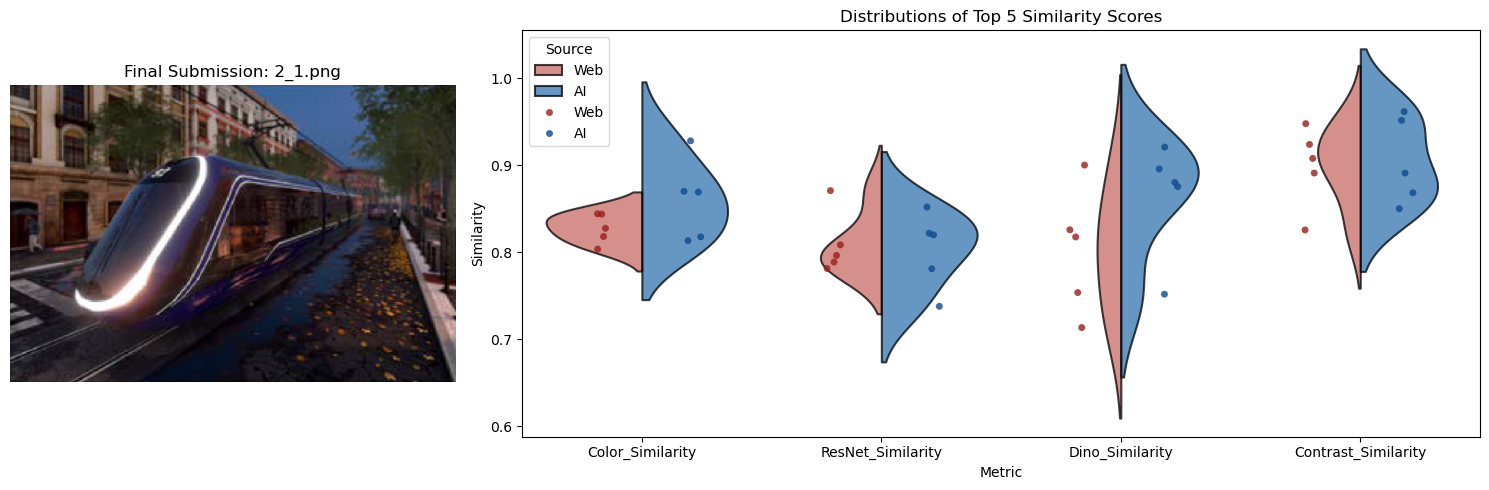

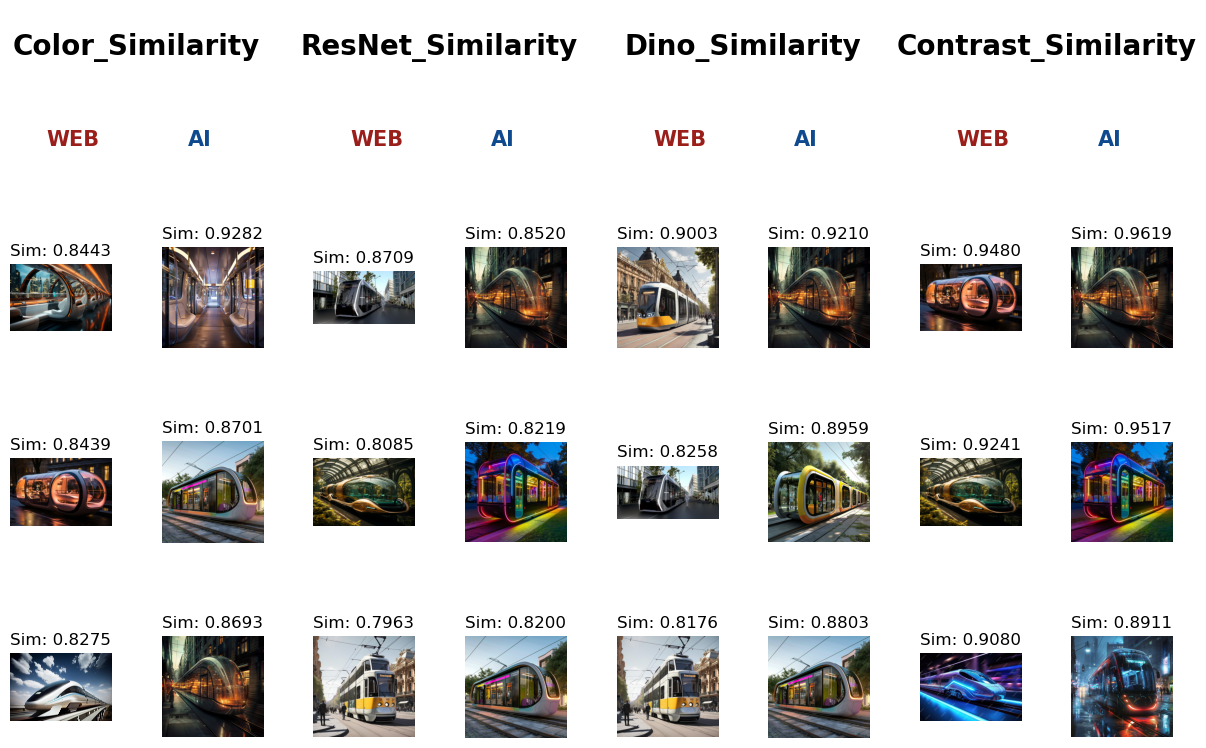

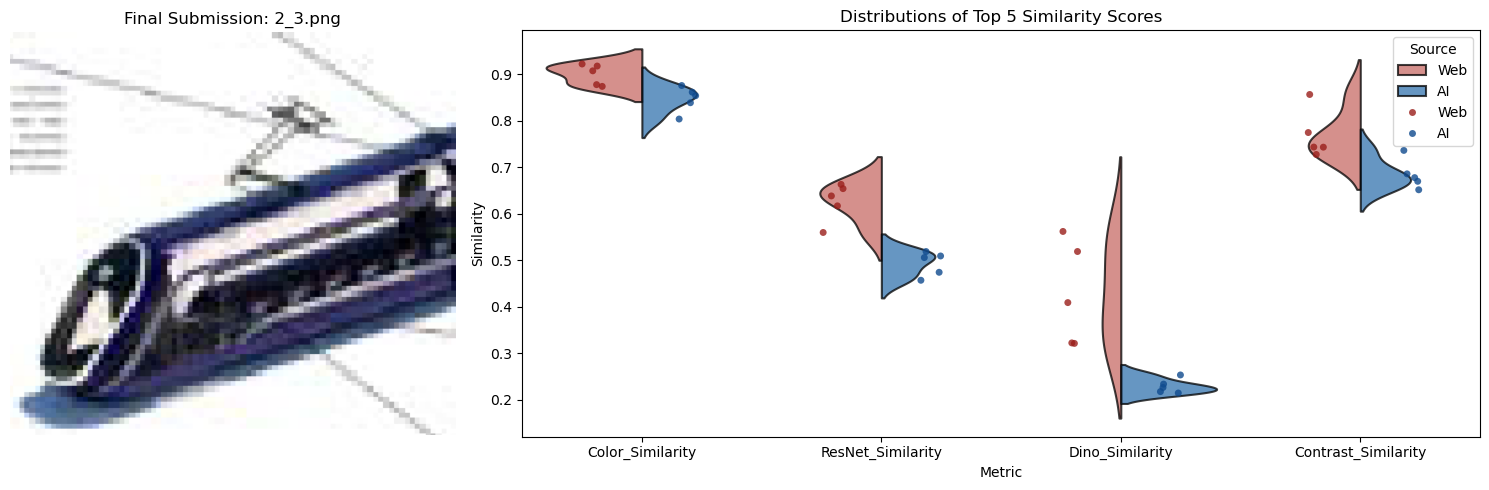

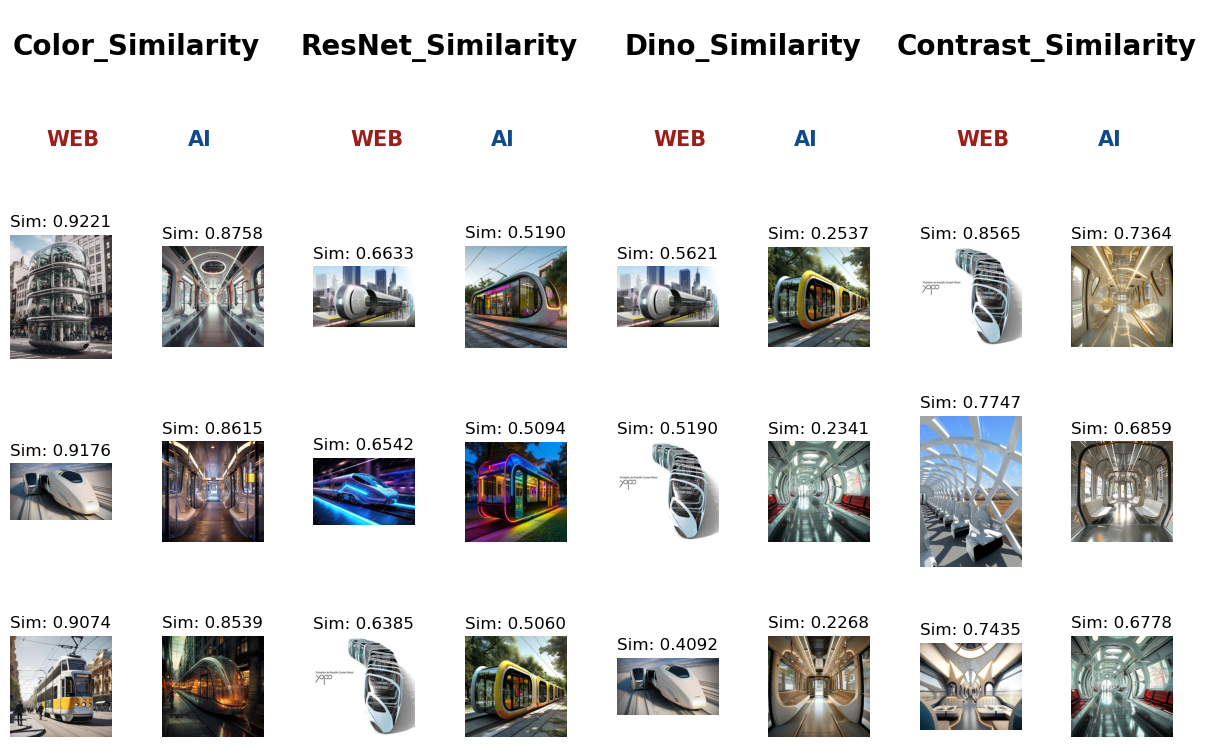

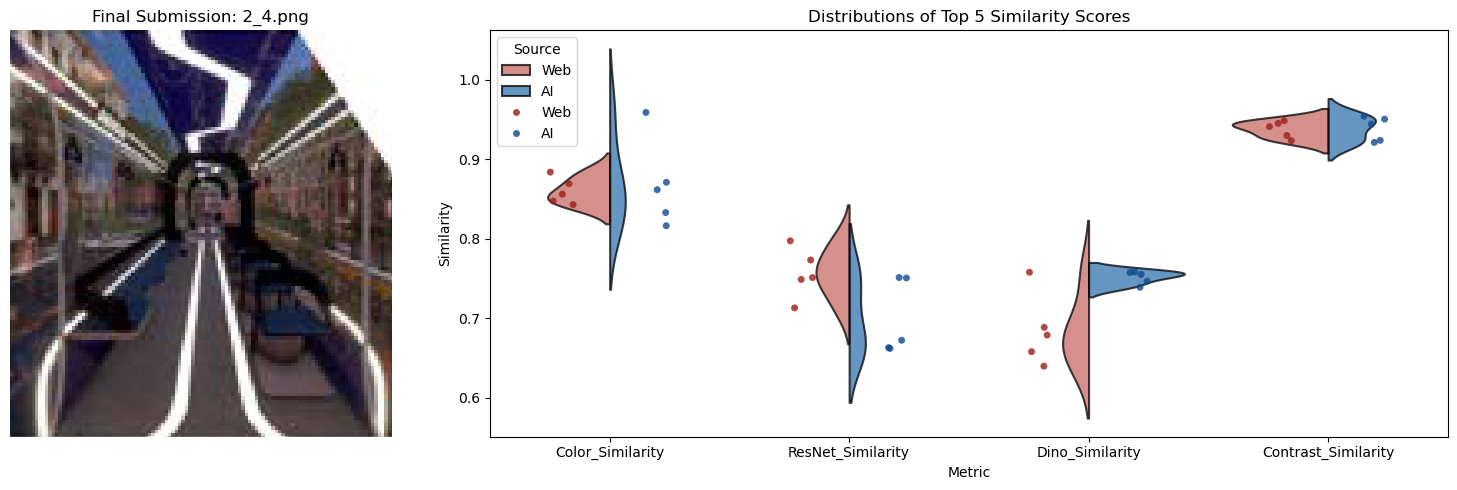

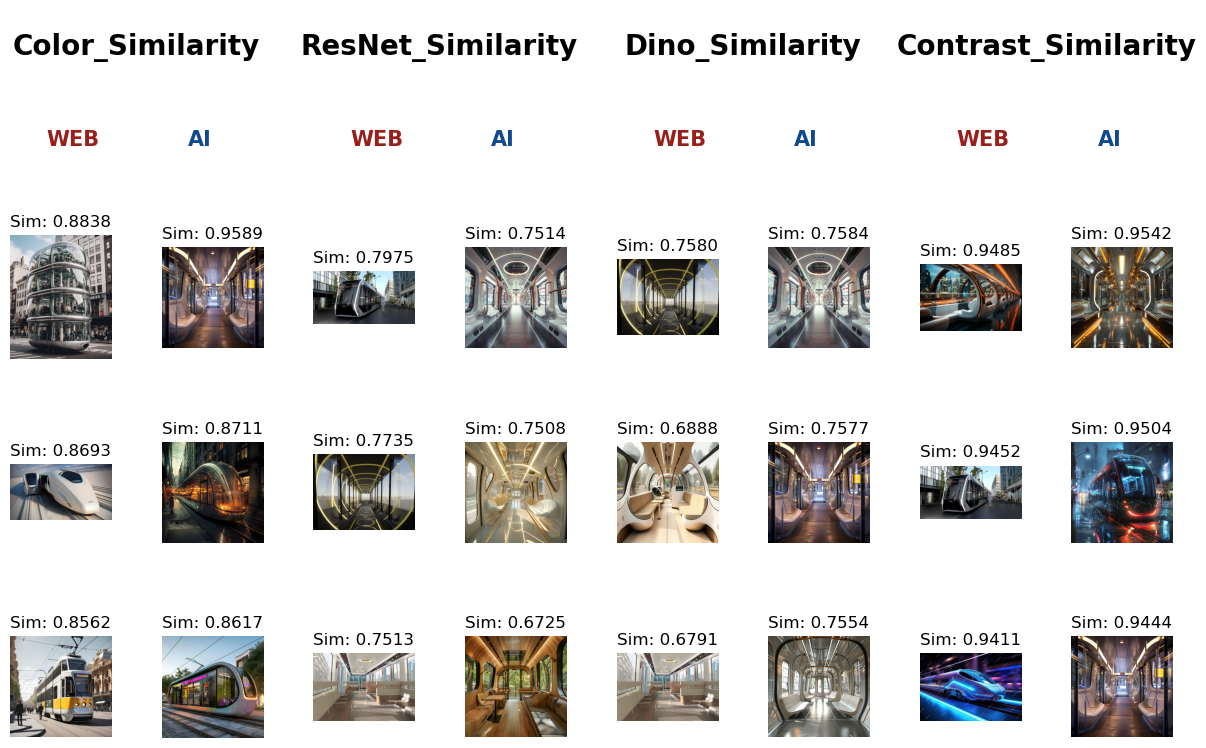

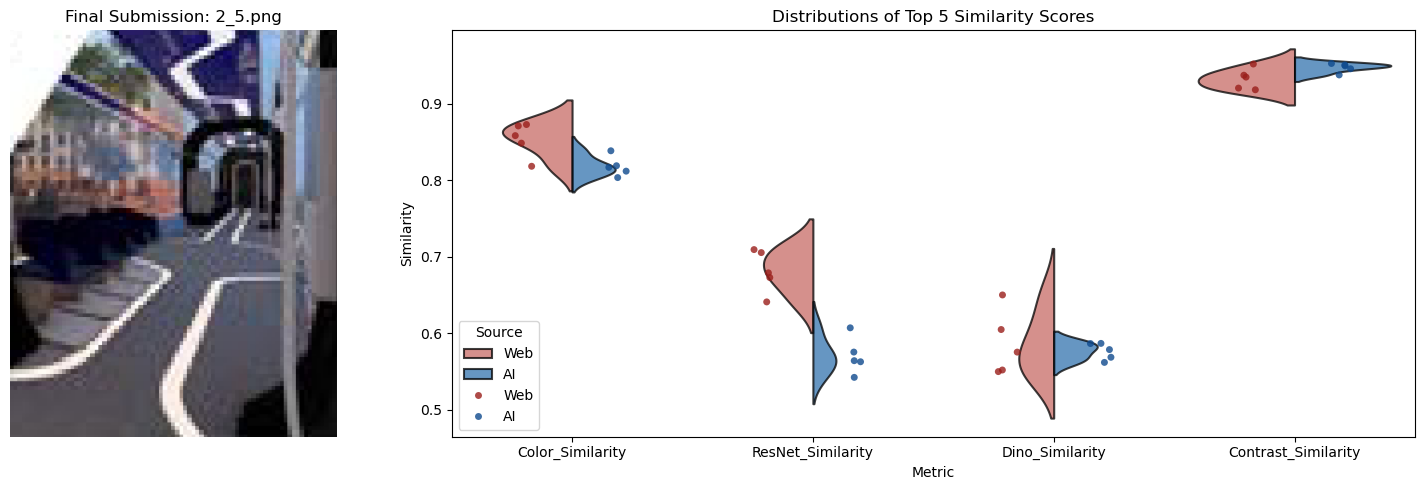

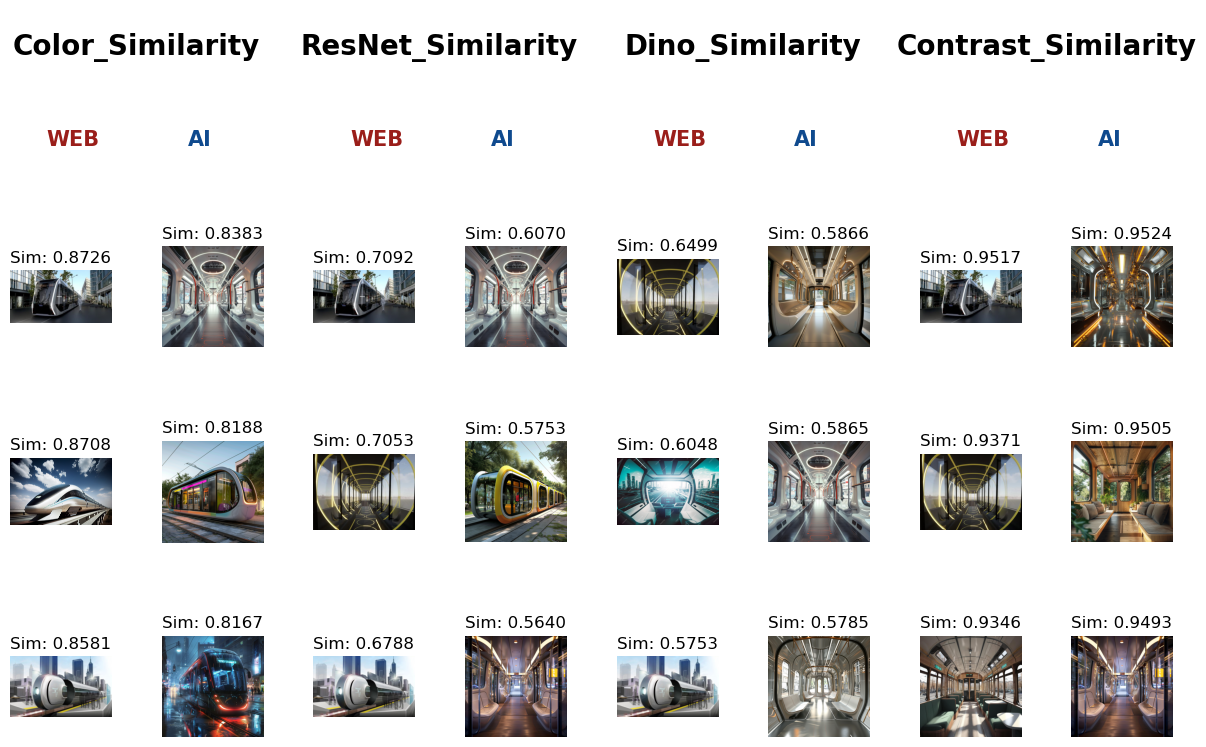

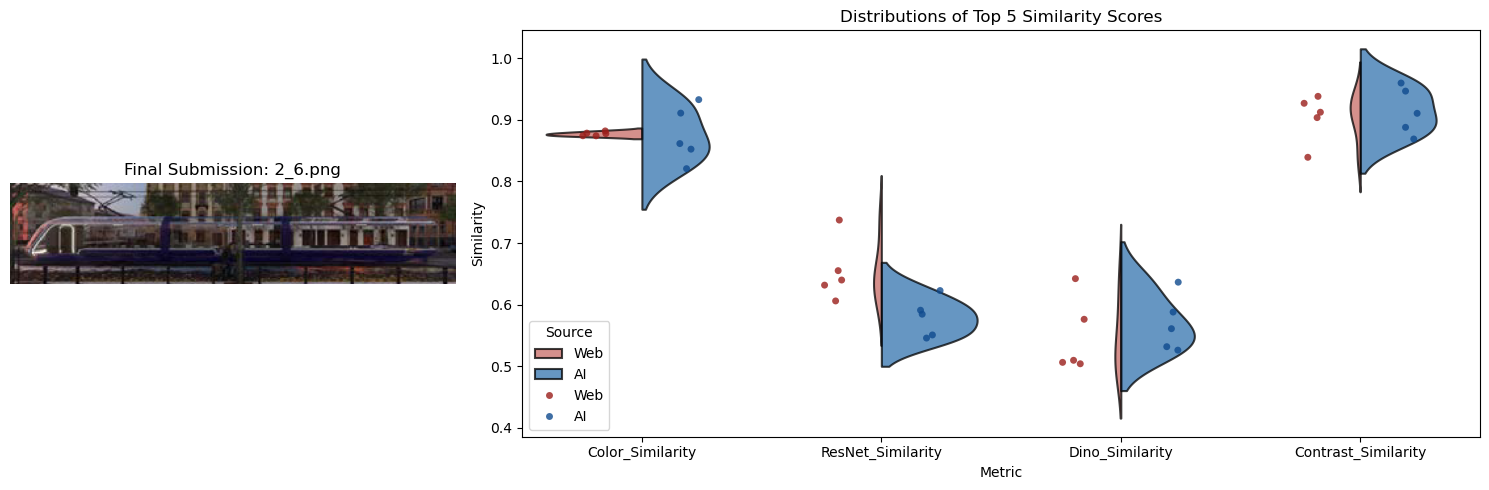

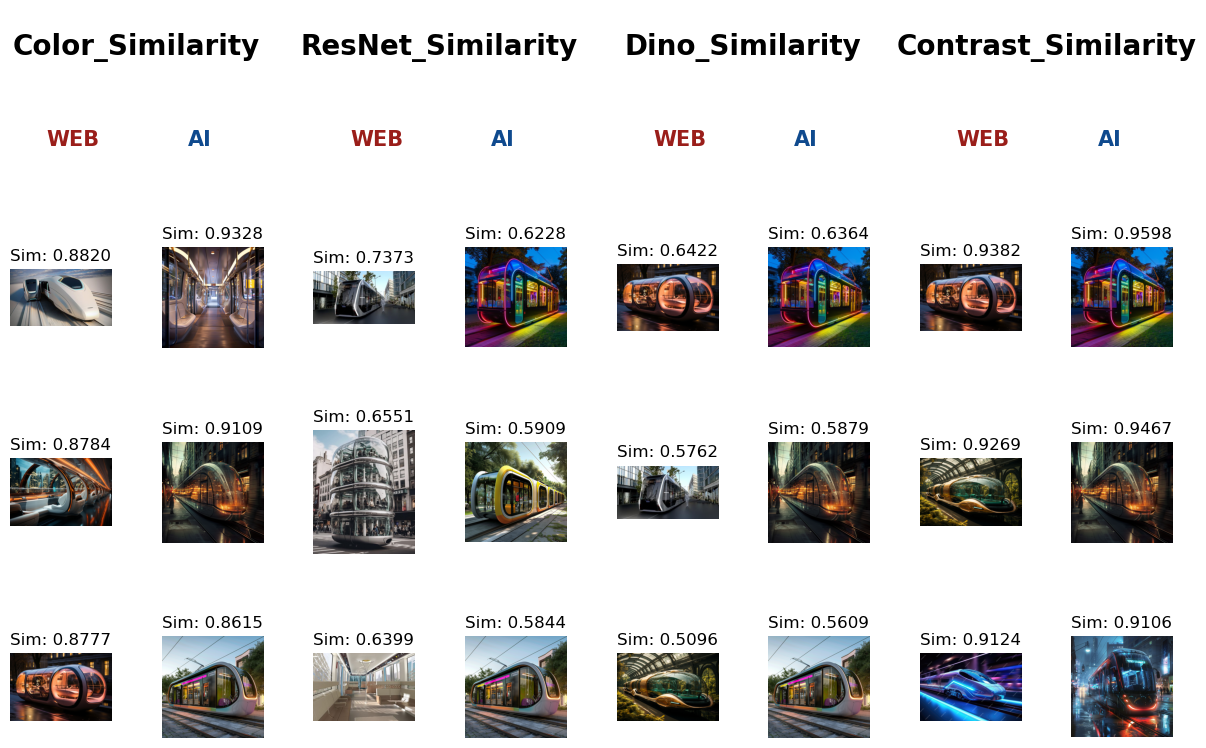

In [25]:
metrics = [
    "Color_Similarity",
    "ResNet_Similarity",
    "Dino_Similarity",
    "Contrast_Similarity",
]


def plot_distriubtion(top_count, image_index, final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs):
    final_src = final_srcs[image_index]
    final_image = final_images[image_index]

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 3, figure=fig)

    ax_final_submission = fig.add_subplot(gs[0, 0])
    imshow_on_axis(final_image, ax_final_submission, f"Final Submission: {final_src}")

    filtered_df = combined_df[combined_df["Final_Submission"] == final_src]

    combined_df_melted = pd.melt(
        filtered_df,
        id_vars=["Source"],
        value_vars=metrics,
        var_name="Metric",
        value_name="Similarity",
    )
    
    combined_df_melted["Metric"] = pd.Categorical(
        combined_df_melted["Metric"], categories=metrics, ordered=True
    )
    
    top_similarities = combined_df_melted
    
    if top_count != "all":
        top_similarities = (
            combined_df_melted.sort_values(
                ["Metric", "Source", "Similarity"],
                ascending=[True, False, False],
            )
            .groupby(["Metric", "Source"], observed=True)
            .head(top_count)
        )
        
    custom_palette = {"AI": "#1E74C3", "Web": "#D85C56"}
    strip_palette = {"AI": "#0F4A8E", "Web": "#9A1E1A"}
    
    ax_sin = fig.add_subplot(gs[0, 1:3])
    
    sns.violinplot(
        x="Metric",
        y="Similarity",
        hue="Source",
        data=top_similarities,
        inner=None,
        linewidth=1.5,
        split=True,
        palette=custom_palette,
        alpha=0.75,
        edgecolor="black",
        ax=ax_sin,
    )
    
    sns.stripplot(
        x="Metric",
        y="Similarity",
        hue="Source",
        data=top_similarities,
        palette=strip_palette,
        jitter=True,
        alpha=0.8,
        size=5,
        dodge=True,
        ax=ax_sin,
    )
    
    ax_sin.set_title(f"Distributions of Top {top_count} Similarity Scores")
    ax_sin.set_xlabel("Metric")
    ax_sin.set_ylabel("Similarity")
    plt.tight_layout()
    plt.show()

def show_top_inspirations(top_count, image_index, final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs):
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(top_count + 1, 8, figure=fig, wspace=0.5, hspace=0.05)
    
    
    
    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(gs[0, i*2:i*2+2])
        ax.text(0.5, 0.8, metric, fontsize=20, fontweight="bold", ha="center", va="center", color="#000000")
        
        # "WEB" label
        ax.text(0.25, 0.3, "WEB", fontsize=15, fontweight="bold", ha="center", va="center", color="#9A1E1A")
        
        # "AI" label
        ax.text(0.75, 0.3, "AI", fontsize=15, fontweight="bold", ha="center", va="center", color="#0F4A8E")
        
        ax.axis("off")
        
        
        new_df = combined_df[combined_df["Final_Submission"] == final_srcs[image_index]]
        new_df_web = new_df[new_df["Source"] == "Web"]
        new_df_ai = new_df[new_df["Source"] == "AI"]
        
        top_web = new_df_web.sort_values(by=metric, ascending=False).head(top_count)
        top_ai = new_df_ai.sort_values(by=metric, ascending=False).head(top_count)
        
        for j in range(top_count):
            web_image = web_images[web_srcs.index(top_web.iloc[j]["Inspiration"])]
            ai_image = ai_images[ai_srcs.index(top_ai.iloc[j]["Inspiration"])]
            
            ax_web = fig.add_subplot(gs[j+1, i*2])
            imshow_on_axis(web_image, ax_web, f"Sim: {top_web.iloc[j][metric]:.4f}")
            
            ax_ai = fig.add_subplot(gs[j+1, i*2+1])
            imshow_on_axis(ai_image, ax_ai, f"Sim: {top_ai.iloc[j][metric]:.4f}")
        
    
    plt.show()
    
def show_top_inspirations_metric(group_id,
                                 top_count,
                                 image_index, 
                                 metric, 
                                 final_images = None, 
                                 web_images = None, 
                                 ai_images = None, 
                                 final_srcs = None, 
                                 web_srcs = None, 
                                 ai_srcs = None):
    if not final_images:
        final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs = load_images(
            group_id
        )
    
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(3, top_count + 3)
    
    ax_title = fig.add_subplot(gs[0, 0:6])
    ax_title.text(0.5, 0.5, f"Top {top_count} Inspirations given {metric}", fontsize=20, fontweight="bold", ha="center", va="center", color="#000000")
    ax_title.axis("off")
    
    ax_final_submission = fig.add_subplot(gs[1:3, 0:2])
    imshow_on_axis(final_images[image_index], ax_final_submission, f"Final Submission: {final_srcs[image_index]}")
    
    ax = fig.add_subplot(gs[1, 2])
    ax.text(0.5, 0.5, "WEB", fontsize=30, fontweight="bold", ha="center", va="center", color="#9A1E1A")
    ax.axis("off")
    
    ax = fig.add_subplot(gs[2, 2])
    ax.text(0.5, 0.5, "AI", fontsize=30, fontweight="bold", ha="center", va="center", color="#0F4A8E")
    ax.axis("off")
    
    new_df = combined_df[combined_df["Final_Submission"] == final_srcs[image_index]]
    new_df_web = new_df[new_df["Source"] == "Web"]
    new_df_ai = new_df[new_df["Source"] == "AI"]
    
    top_web = new_df_web.sort_values(by=metric, ascending=False).head(top_count)
    top_ai = new_df_ai.sort_values(by=metric, ascending=False).head(top_count)
    
    for i in range(top_count):
        web_image = web_images[web_srcs.index(top_web.iloc[i]["Inspiration"])]
        ai_image = ai_images[ai_srcs.index(top_ai.iloc[i]["Inspiration"])]
        
        ax_web = fig.add_subplot(gs[1, i+3])
        imshow_on_axis(web_image, ax_web, f"Sim: {top_web.iloc[i][metric]:.4f}")
        
        ax_ai = fig.add_subplot(gs[2, i+3])
        imshow_on_axis(ai_image, ax_ai, f"Sim: {top_ai.iloc[i][metric]:.4f}")
    
    plt.tight_layout()
    plt.show()
    

def analyze_group(group_id, top_count_distr = None, top_count_imgs = None):
    final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs = load_images(
        group_id
    )
    
    for i in range(len(final_srcs)):
        if top_count_distr: plot_distriubtion(top_count_distr, i, final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs)
        if top_count_imgs: show_top_inspirations(top_count_imgs, i, final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs)


#How to use plotting functions above
#Invoking analyze_group plotting both distributions and all top images can take a long time since a lot of images are being generated
#By not giving a parameter regarding one of the top counts be it distribution or showing images the respective part of the analyze_group won't get invoked
#There is also function show_top_inspiration_metric which can be used to plot just top n inspiration for a given metric

#What i recommend is to see the distributions of top_n inspirations for all/ most groups,
# try to find some interesting differences in distribution in a given metric and just show top 3 inspirations for a given final_image and given metric

analyze_group(2, 5, 3)


# Is the inspiration conscious or subconscious?


In [16]:
def fix_name(name: str) -> str:
    name = name.strip().lower().split()
    name.sort()
    return ' '.join(name)

In [17]:
summary_survey = read_csv("data/Summary_Survey.csv")
summary_survey.columns = [c if c!="1. Imię i Nazwisko" else "Name" for c in summary_survey.columns ]
summary_survey["Name"] = summary_survey["Name"].apply(fix_name)
summary_survey.head()

Sygnatura czasowa                  Name  \
0  2024/06/05 5:25:29 PM EEST          daria kachan   
1  2024/06/05 5:47:56 PM EEST  domagalska magdalena   
2  2024/06/05 5:48:16 PM EEST      bukowska daniela   
3  2024/06/05 5:49:40 PM EEST      milena sielewicz   
4  2024/06/05 5:51:23 PM EEST         iryna sidaruk   

    2. Nr grupy dziekańskiej  \
0  AWWA gr. 1.1 (II stopień)   
1  AWWA gr. 1.1 (II stopień)   
2  AWWA gr. 1.1 (II stopień)   
3  AWWA gr. 1.1 (II stopień)   
4  AWWA gr. 1.1 (II stopień)   

   3. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt EFEKTU ZASKOCZENIA:  \
0                                                 10                                                                                                                                                                     
1                                                 15                                                                                                                                                                     
2                                                 17                                                                                                                                                                     
3                                                 12                                                                                                                                                                     
4                                                  5                                                                                                                                                                     

   4. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt INNOWACYJNOŚCI ROZWIĄZAŃ:  \
0                                                 11                                                                                                                                                                           
1                                                 20                                                                                                                                                                           
2                                                 12                                                                                                                                                                           
3                                                  3                                                                                                                                                                           
4                                                 14                                                                                                                                                                           

   5. Wybierz obrazek spośród wszystkich zgromadzonych inspiracji (1-20) i wskaż ten, który miał największe znaczenie dla osiągniętego efektu projektowego (finalnej koncepcji), z uwagi na aspekt JAKOŚCI WIZUALNEJ:  \
0                                                 11                                                                                                                                                                    
1                                                 20                                                                                                                                                                    
2                                                 12                                                                                                                                   

In [18]:
from utilities import get_participants

participants = get_participants()
participants["Name"] = participants["Name"].apply(fix_name)
participants.head()

Name  ID GroupID  \
1            daria kachan  1A       1   
2  aleksandra skolimowska  1B       1   
3           iryna sidaruk  2A       2   
4     agnieszka musielska  2B       2   
5    domagalska magdalena  3A       3   

                                    WEB_inspirations  \
1  [data/web/1A_1.jpg, data/web/1A_10.jpg, data/w...   
2  [data/web/1B_1.JPG, data/web/1B_10.JPG, data/w...   
3  [data/web/2A_1.jpg, data/web/2A_10.jpg, data/w...   
4  [data/web/2B_1.jpg, data/web/2B_10.jpg, data/w...   
5  [data/web/3A_1.png, data/web/3A_10.png, data/w...   

                                     AI_inspirations  \
1  [data/ai/1A_11.png, data/ai/1A_12.png, data/ai...   
2  [data/ai/1B_11.png, data/ai/1B_12_1.png, data/...   
3  [data/ai/2A_11.png, data/ai/2A_12.png, data/ai...   
4  [data/ai/2B_11.png, data/ai/2B_12.png, data/ai...   
5  [data/ai/3A_11.png, data/ai/3A_12.png, data/ai...   

                                    Final_submisions Matrices Comment  
1  [data/final_submissions/1/1.png, data/final_su...     M_1A     NaN  
2  [data/final_submissions/1/1.png, data/final_su...     M_1B     NaN  
3  [data/final_submissions/2/1.png, data/final_su...     M_2A     NaN  
4  [data/final_submissions/2/1.png, data/final_su...     M_2B     NaN  
5  [data/final_submissions/3/1.png, data/final_su...     M_3A     NaN

In [19]:
merged_participants = pd.merge(participants, summary_survey, on="Name",how="inner")

pick_column_match_text = lambda text: [c for c in merged_participants.columns if text.lower() in c.lower()][0]

merged_participants = merged_participants.drop(columns = [
    "Sygnatura czasowa",
    "2. Nr grupy dziekańskiej",
    "Comment","10. Miejsce na dodatkowe komentarze/ uwagi:",
    pick_column_match_text("EFEKTU ZASKOCZENIA"),
    pick_column_match_text("INNOWACYJNOŚCI ROZWIĄZAŃ"),
    pick_column_match_text("JAKOŚCI WIZUALNEJ"),
    pick_column_match_text("NASTROJU SCENY"),
    pick_column_match_text("ZESTAWIEŃ MATERIAŁOWYCH"),])

merged_participants.columns = ["Name",	"ID",	"GroupID",	"WEB_inspirations",	"AI_inspirations",	"Final_submisions",	"Matrices", "Assumed Top Color", "Assumed Top Overall"]
merged_participants["ID"] = [str(x) for x in merged_participants["ID"]]
merged_participants.head()

Name  ID GroupID  \
0            daria kachan  1A       1   
1  aleksandra skolimowska  1B       1   
2           iryna sidaruk  2A       2   
3     agnieszka musielska  2B       2   
4    domagalska magdalena  3A       3   

                                    WEB_inspirations  \
0  [data/web/1A_1.jpg, data/web/1A_10.jpg, data/w...   
1  [data/web/1B_1.JPG, data/web/1B_10.JPG, data/w...   
2  [data/web/2A_1.jpg, data/web/2A_10.jpg, data/w...   
3  [data/web/2B_1.jpg, data/web/2B_10.jpg, data/w...   
4  [data/web/3A_1.png, data/web/3A_10.png, data/w...   

                                     AI_inspirations  \
0  [data/ai/1A_11.png, data/ai/1A_12.png, data/ai...   
1  [data/ai/1B_11.png, data/ai/1B_12_1.png, data/...   
2  [data/ai/2A_11.png, data/ai/2A_12.png, data/ai...   
3  [data/ai/2B_11.png, data/ai/2B_12.png, data/ai...   
4  [data/ai/3A_11.png, data/ai/3A_12.png, data/ai...   

                                    Final_submisions Matrices  \
0  [data/final_submissions/1/1.png, data/final_su...     M_1A   
1  [data/final_submissions/1/1.png, data/final_su...     M_1B   
2  [data/final_submissions/2/1.png, data/final_su...     M_2A   
3  [data/final_submissions/2/1.png, data/final_su...     M_2B   
4  [data/final_submissions/3/1.png, data/final_su...     M_3A   

   Assumed Top Color  Assumed Top Overall  
0                 11                   11  
1                  4                    3  
2                  1                   16  
3                 11                   12  
4                 14                   16

In [20]:
merge_all["ID"] = merge_all["Inspiration"].apply(lambda x: (x.split("_")[0]))

In [21]:
def get_top_inspiration(participant_id,similarity_type,n=1):
    participant_images = merge_all[merge_all["ID"] == participant_id]
    mean_inspiration = participant_images.groupby("Inspiration")[similarity_type].median().reset_index()
    #print(mean_inspiration)
    insp = mean_inspiration.sort_values(by=similarity_type, ascending=False).head(n)
    insp["image_id"] = insp["Inspiration"].apply(lambda x: x.split("_")[1].split(".")[0])
    return insp.reset_index(drop=True)

def get_id_position_in_top(participant_id, similarity_type,image_id):
    top_all = get_top_inspiration(participant_id,similarity_type,n=10000)
    if image_id not in top_all["image_id"].values:
        return None
    return top_all[top_all["image_id"]==image_id].index[0]+1

In [22]:
merged_participants["Calculated Top Color"] = merged_participants["ID"].apply(lambda x: get_top_inspiration(x, "Color_Similarity")["image_id"].values[0])
merged_participants["Calculated Top Overall"] = merged_participants["ID"].apply(lambda x: get_top_inspiration(x, "Dino_Similarity")["image_id"].values[0])

merged_participants["Assumed Top Color Rank"] = merged_participants.apply(lambda row: get_id_position_in_top(row["ID"],"Color_Similarity",str(row["Assumed Top Color"])), axis=1)
merged_participants["Assumed Top Overall Rank"] = merged_participants.apply(lambda row: get_id_position_in_top(row["ID"],"Dino_Similarity",str(row["Assumed Top Overall"])), axis=1)
merged_participants["Total Inspiration Images"] = merged_participants.apply(lambda row: len(row["WEB_inspirations"]) + len(row["AI_inspirations"]), axis=1)

In [23]:
merged_participants[["ID","Assumed Top Color","Calculated Top Color","Assumed Top Color Rank","Total Inspiration Images"]]

ID  Assumed Top Color Calculated Top Color  Assumed Top Color Rank  \
0    1A                 11                   10                    11.0   
1    1B                  4                    7                     3.0   
2    2A                  1                    3                     7.0   
3    2B                 11                   11                     1.0   
4    3A                 14                    6                     9.0   
5    3B                  5                    5                     1.0   
6    4A                 10                   10                     1.0   
7    4B                  8                    2                     3.0   
8    5A                  1                    4                     2.0   
9    5B                 14                   17                     8.0   
10   6B                  2                    9                    16.0   
11   7A                  8                    6                    13.0   
12   7B                  6                   11                     2.0   
13   7C                 19                   12                    16.0   
14   8A                 15                    8                     5.0   
15   8B                  9                    4                     8.0   
16   9A                 14                   13                     4.0   
17   9B                 13                   16                     7.0   
18  10A                  2                    1                     9.0   
19  10B                 11                   13                    12.0   
20  11A                 13                    7                    12.0   
21  11B                 12                   11                    16.0   
22  12A                  6                    8                     6.0   
23  12B                 11                    2                     NaN   
24  13A                  3                   18                     5.0   
25  13B                  4                   14                     8.0   
26  14A                 12                    3                    14.0   
27  14B                  7                    1                    16.0   
28  15A                 16                    3                     8.0   
29  15B                 16                    2                     2.0   
30  16B                  3                    9                    13.0   
31  17A                  1                   11                     3.0   
32  17B                  2                   18                    16.0   
33  18A                  8                    1                    11.0   
34  18B                 14                    4                    17.0   
35  19A                  3                    4                     3.0   
36  20B                 13                    1                    16.0   
37  21A                 11                    6                    10.0   
38  22A                 16                    8                    14.0   
39  23A                 11                   10                     9.0   
40  23B                 10                    7                     7.0   
41  24A                 12                    4                     4.0   
42  24B                 12                   15                     3.0   
43   25                 17                    8                    12.0   
44   27                  8                    6                    16.0   

    Total Inspiration Images  
0                         13  
1                         36  
2                         16  
3                         18  
4                         20  
5                         20  
6                         15  
7                         20  
8                         16  
9                         15  
10                        19  
11                        20  
12                        11  
13                        20  
14                        20  
15                        20  
16                        1

In [24]:
merged_participants[["ID","Assumed Top Overall","Calculated Top Overall","Assumed Top Overall Rank","Total Inspiration Images"]]

ID  Assumed Top Overall Calculated Top Overall  Assumed Top Overall Rank  \
0    1A                   11                     13                       2.0   
1    1B                    3                     12                      31.0   
2    2A                   16                      7                       3.0   
3    2B                   12                      5                       6.0   
4    3A                   16                      9                       9.0   
5    3B                   12                      8                      15.0   
6    4A                   12                     14                      10.0   
7    4B                    8                      4                       2.0   
8    5A                    1                      9                      16.0   
9    5B                   16                      9                       8.0   
10   6B                    9                     17                      19.0   
11   7A                    8                      6                       8.0   
12   7B                    6                      5                       2.0   
13   7C                   17                     20                       5.0   
14   8A                   15                      2                       5.0   
15   8B                   12                     16                       7.0   
16   9A                   14                     12                       4.0   
17   9B                   13                      4                       3.0   
18  10A                   12                      5                      15.0   
19  10B                    4                     12                      14.0   
20  11A                    6                      3                      14.0   
21  11B                   14                     12                       7.0   
22  12A                    8                     14                      14.0   
23  12B                   11                      6                       NaN   
24  13A                    3                      2                       9.0   
25  13B                    4                     10                      19.0   
26  14A                   13                     15                       9.0   
27  14B                   19                     13                       4.0   
28  15A                    1                      8                      10.0   
29  15B                   16                      2                       8.0   
30  16B                    9                     12                      13.0   
31  17A                    7                      3                       5.0   
32  17B                   12                      2                      13.0   
33  18A                   15                     14                      18.0   
34  18B                    4                      6                      14.0   
35  19A                    4                     20                      14.0   
36  20B                   14                     11                       7.0   
37  21A                   19                     20                       8.0   
38  22A                    6                     20                      16.0   
39  23A                   12                     14                       6.0   
40  23B                    4                     10                       9.0   
41  24A                   13                      7                       9.0   
42  24B                   16                      3                       2.0   
43   25                   19                     12                      11.0   
44   27                   16                      6                       3.0   

    Total Inspiration Images  
0                         13  
1                         36  
2                         16  
3                         18  
4                         20  
5                         20  
6                         15  
7                         20  